In [17]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy.typing import NDArray
from typing import TypeAlias
import lib_quaternion as lib_q

In [18]:
Vec3: TypeAlias = NDArray[np.float64]
Quat: TypeAlias = NDArray[np.float64]

In [19]:
# -----------------------------
# Paths
# -----------------------------
root: Path = Path.cwd().parent
run_dir: Path = root / "data" / "21:08_oct_07_2025_5min"

ori_path: Path = run_dir / "Orientation.csv"
gyro_path: Path = run_dir / "Gyroscope.csv"
grav_path: Path = run_dir / "Gravity.csv"
acc_path: Path = run_dir / "AccelerometerUncalibrated.csv"
mag_path: Path = run_dir / "Magnetometer.csv"

for p in [ori_path, gyro_path, grav_path, acc_path, mag_path]:
        if not p.exists():
                raise FileNotFoundError(f"File not found: {p}")

In [20]:
# -----------------------------
# Load Orientation — ref (qz, qy, qx, qw order in csv file)
# -----------------------------
ori_cols: list[str] = ["seconds_elapsed", "qw", "qx", "qy", "qz"]

ori: pd.DataFrame = pd.read_csv(ori_path, usecols=["seconds_elapsed", "qz", "qy", "qx", "qw"])
ori[ori_cols] = ori[ori_cols].apply(pd.to_numeric, errors="coerce")
ori = ori.dropna(subset=ori_cols).sort_values("seconds_elapsed").reset_index(drop=True)
ori = ori[ori_cols]

t_ref: NDArray[np.float64] = ori["seconds_elapsed"].to_numpy()
q_ref: NDArray[np.float64] = ori[["qw", "qx", "qy", "qz"]].to_numpy()

#fix ref quaternion sign continuity
for i in range(1, len(q_ref)):
        if np.dot(q_ref[i - 1], q_ref[i]) < 0:
                q_ref[i] *= -1

In [21]:
# -----------------------------
# Load Gyroscope — calibrated (z, y, x order in csv file)
# -----------------------------
gyro_cols: list[str] = ["seconds_elapsed", "x", "y", "z"]

gyro: pd.DataFrame = pd.read_csv(gyro_path, usecols=["seconds_elapsed", "z", "y", "x"])
gyro[gyro_cols] = gyro[gyro_cols].apply(pd.to_numeric, errors="coerce")
gyro = gyro.dropna(subset=gyro_cols).sort_values("seconds_elapsed").reset_index(drop=True)
gyro = gyro[gyro_cols]

t_gyro_tmp: NDArray[np.float64] = gyro["seconds_elapsed"].to_numpy()
w: NDArray[np.float64]= gyro[["x", "y", "z"]].to_numpy()

dt: NDArray[np.float64] = np.diff(t_gyro_tmp)
t_custom: NDArray[np.float64] = t_gyro_tmp[1:]
w_gyro: NDArray[np.float64] = w[1:]
w_average: NDArray[np.float64]= 0.5 * (w[1:] + w[:-1]) # section average angular velocity

idx0: int = np.argmin(np.abs(t_ref - t_custom[0]))
q0: Quat = lib_q.quat_norm(q_ref[idx0].copy())

In [22]:
# -----------------------------
# Gyro-only integration
# -----------------------------
q: Quat = q0.copy()
q_custom_gyro: NDArray[np.float64] = np.zeros((len(dt), 4), dtype=np.float64)

for i in range(len(dt)):
        dq: Quat = lib_q.delta_quat_from_omega(w_average[i], dt[i])
        q = lib_q.quat_mul(q, dq)
        q = lib_q.quat_norm(q)
        q_custom_gyro[i] = q

# interpolate gyro onto t_custom
q_ref_interp: NDArray[np.float64] = np.column_stack([
        np.interp(t_custom, t_ref, q_ref[:, 0]), #qw
        np.interp(t_custom, t_ref, q_ref[:, 1]), #qx
        np.interp(t_custom, t_ref, q_ref[:, 2]), #qy
        np.interp(t_custom, t_ref, q_ref[:, 3])  #qz
]).astype(np.float64)

q_ref_interp /= np.linalg.norm(q_ref_interp, axis=1, keepdims=True)

angle_err_gyro: NDArray[np.float64] = lib_q.calc_angle_err(q_custom_gyro, q_ref_interp)

print("Gyro-only angle_err (rad): min/max/mean",
        float(angle_err_gyro.min()), float(angle_err_gyro.max()), float(angle_err_gyro.mean()))
print("Gyro-only angle_err (deg): min/max/mean",
        float(np.rad2deg(angle_err_gyro.min())),
        float(np.rad2deg(angle_err_gyro.max())),
        float(np.rad2deg(angle_err_gyro.mean())))

Gyro-only angle_err (rad): min/max/mean 0.016900799939842653 1.0850920070565426 0.5475108313340219
Gyro-only angle_err (deg): min/max/mean 0.9683445069479396 62.171192387719636 31.370059873138523


In [23]:
# -----------------------------
# Load Gravity (z, y, x order in csv file)
# -----------------------------
grav_cols: list[str] = ["seconds_elapsed", "x", "y", "z"]

grav = pd.read_csv(grav_path, usecols=["seconds_elapsed", "z", "y", "x"])
grav[grav_cols] = grav[grav_cols].apply(pd.to_numeric, errors="coerce")
grav = grav.dropna(subset=grav_cols).sort_values("seconds_elapsed").reset_index(drop=True)
grav = grav[grav_cols]

t_grav: NDArray[np.float64] = grav["seconds_elapsed"].to_numpy(dtype=np.float64)
g: NDArray[np.float64] = grav[["x", "y", "z"]].to_numpy()

# interpolate gravity onto t_custom
grav_interp: NDArray[np.float64] = np.column_stack([
        np.interp(t_custom, t_grav, g[:, 0]),
        np.interp(t_custom, t_grav, g[:, 1]),
        np.interp(t_custom, t_grav, g[:, 2])
]).astype(np.float64)

grav_interp /= np.linalg.norm(grav_interp, axis=1, keepdims=True)

In [24]:
# -----------------------------
# Gyro + Gravity correction
# -----------------------------
K: float = 0.05
g_world: Vec3 = np.array([0.0, 0.0, -1.0], dtype=np.float64)

q: Quat = q0.copy()
q_custom_gyro_grav: NDArray[np.float64] = np.zeros((len(dt), 4), dtype=np.float64)

for i in range(len(dt)):
        # predict (gyro)
        dq: Quat = lib_q.delta_quat_from_omega(w_average[i], dt[i])
        q_pred: Quat = lib_q.quat_mul(q, dq)
        q_pred = lib_q.quat_norm(q_pred)

        # predict (grav)
        g_pred: Vec3 = lib_q.rotate_world_to_body(q_pred, g_world)
        g_pred /= max(float(np.linalg.norm(g_pred)), 1e-9)
        g_body: Vec3 = grav_interp[i]

        # gravity correction
        err_axis: Vec3 = np.cross(g_pred, g_body)
        dq_corr: Quat = np.array([
                1.0,
                0.5 * K * err_axis[0],
                0.5 * K * err_axis[1],
                0.5 * K * err_axis[2]],
                dtype=np.float64)
        dq_corr = lib_q.quat_norm(dq_corr)

        q = lib_q.quat_mul(q_pred, dq_corr)
        q = lib_q.quat_norm(q)
        q_custom_gyro_grav[i] = q

angle_err_gyro_grav: NDArray[np.float64] = lib_q.calc_angle_err(q_custom_gyro_grav, q_ref_interp)

print("Gyro+Gravity angle_err (rad): min/max/mean",
      float(angle_err_gyro_grav.min()),
      float(angle_err_gyro_grav.max()),
      float(angle_err_gyro_grav.mean()))
print("Gyro+Gravity angle_err (deg): min/max/mean",
      float(np.rad2deg(angle_err_gyro_grav.min())),
      float(np.rad2deg(angle_err_gyro_grav.max())),
      float(np.rad2deg(angle_err_gyro_grav.mean())))

Gyro+Gravity angle_err (rad): min/max/mean 0.0002787963696693779 0.951452095442838 0.1905944435717342
Gyro+Gravity angle_err (deg): min/max/mean 0.015973855325624467 54.51418947775301 10.920257215304693


In [25]:
# -----------------------------
# Load Accelerometer — uncalibrated (z, y, x order in csv file)
# -----------------------------
acc_cols: list[str] = ["seconds_elapsed", "x", "y", "z"]

acc: pd.DataFrame = pd.read_csv(acc_path, usecols=["seconds_elapsed", "z", "y", "x"])
acc[acc_cols] = acc[acc_cols].apply(pd.to_numeric, errors="coerce")
acc = acc.dropna(subset=acc_cols).sort_values("seconds_elapsed").reset_index(drop=True)
acc = acc[acc_cols]

t_acc: NDArray[np.float64] = acc["seconds_elapsed"].to_numpy(dtype=np.float64)
a_net: NDArray[np.float64] = acc[["x", "y", "z"]].to_numpy(dtype=np.float64)

# interpolate accel onto t_custom
a_net_interp: NDArray[np.float64] = np.column_stack([
        np.interp(t_custom, t_acc, a_net[:, 0]), #x
        np.interp(t_custom, t_acc, a_net[:, 1]), #y
        np.interp(t_custom, t_acc, a_net[:, 2])  #z
]).astype(np.float64)

In [56]:
# -----------------------------
# Gyro + Accel gravity correction (no Gravity.csv)
# -----------------------------
K: float = 0.05
g0: float = 9.80665
gate_sigma: float = 1.2 # m/s^2, gate softness around |a|-g0

g_world_unit: Vec3 = np.array([0.0, 0.0, -1.0], dtype=np.float64)

q: Quat = q0.copy()
q_custom_gyro_acc: NDArray[np.float64] = np.zeros((len(dt), 4), dtype=np.float64)
g_body_est: NDArray[np.float64] = np.zeros((len(dt), 3), dtype=np.float64)
a_lin_est: NDArray[np.float64] = np.zeros((len(dt), 3), dtype=np.float64)

for i in range(len(dt)):
        # predict (gyro)
        dq: Quat = lib_q.delta_quat_from_omega(w_average[i], dt[i])
        q_pred: Quat = lib_q.quat_mul(q, dq)
        q_pred = lib_q.quat_norm(q_pred)
        
        # predict (grav)
        g_pred: Vec3 = lib_q.rotate_world_to_body(q_pred, g_world_unit)
        g_pred /= max(float(np.linalg.norm(g_pred)), 1e-9)

        # accel measurement direction
        a_unit: Vec3 = a_net_interp[i].copy()
        a_norm: float = np.linalg.norm(a_net_interp[i])
        if a_norm < 1e-9:
                a_unit = g_pred.copy()
        else:
                a_unit = a_unit / a_norm

        # accel trust gating: if |a| deviates from g0, trust less
        dev: float = abs(a_norm - g0)
        # w in [0,1]. 1 near static, 0 high linear acceleration
        acc_weight: float = np.exp(-0.5 * (dev / gate_sigma) ** 2)        

        # gravity correction
        err_axis: Vec3 = np.cross(g_pred, a_unit)
        dq_corr: Quat = np.array([
                1.0,
                0.5 * K * acc_weight * err_axis[0],
                0.5 * K * acc_weight * err_axis[1],
                0.5 * K * acc_weight * err_axis[2]],
                dtype=np.float64)
        dq_corr = lib_q.quat_norm(dq_corr)

        q = lib_q.quat_mul(q_pred, dq_corr)
        q = lib_q.quat_norm(q)
        q_custom_gyro_acc[i] = q

        # estimate gravity in body frame / linear accel
        g_body_est[i] = lib_q.rotate_world_to_body(q, g_world_unit) * g0
        a_lin_est[i] = a_net_interp[i] + g_body_est[i]

angle_err_gyro_acc: NDArray[np.float64] = lib_q.calc_angle_err(q_custom_gyro_acc, q_ref_interp)

print("Gyro+Accel angle_err (rad): min/max/mean",
      float(angle_err_gyro_acc.min()),
      float(angle_err_gyro_acc.max()),
      float(angle_err_gyro_acc.mean()))
print("Gyro+Accel angle_err (deg): min/max/mean",
      float(np.rad2deg(angle_err_gyro_acc.min())),
      float(np.rad2deg(angle_err_gyro_acc.max())),
      float(np.rad2deg(angle_err_gyro_acc.mean())))

Gyro+Accel angle_err (rad): min/max/mean 0.0011642279743390399 1.0182785895290674 0.20244243085556612
Gyro+Accel angle_err (deg): min/max/mean 0.0667053493206921 58.3430655485499 11.59909688239293


In [27]:
# --------------------------------------
# Compare custom gravity vs Gravity.csv
# --------------------------------------
grav_interp: NDArray[np.float64] = np.column_stack([
        np.interp(t_custom, t_grav, g[:, 0]),
        np.interp(t_custom, t_grav, g[:, 1]),
        np.interp(t_custom, t_grav, g[:, 2])
]).astype(np.float64)

print(g_body_est[0])
print(grav_interp[0])

dg: NDArray[np.float64] = (-g_body_est) - grav_interp
g_rmse = np.sqrt(np.mean(dg**2, axis=0))
g_mae = np.mean(np.abs(dg), axis=0)
g_rmse_norm = np.sqrt(np.mean(np.sum(dg*dg, axis=1)))

print("gravity RMSE (x,y,z):", g_rmse)
print("gravity MAE (x,y,z):", g_mae)
print("gravity RMSE norm:", g_rmse_norm)

# optional correlation per axis
def corr3(a, b):
        out = []
        for k in range(3):
                ak = a[:, k]; bk = b[:, k]
                if np.std(ak) < 1e-12 or np.std(bk) < 1e-12:
                        out.append(np.nan)
                else:
                        out.append(np.corrcoef(ak, bk)[0, 1])
        return np.array(out, dtype=np.float64)

print("corr(g_est, g_csv) (x,y,z):", corr3(-g_body_est, grav_interp))

[-1.68533823 -4.07427109 -8.76333556]
[1.78633857 3.95870328 8.79249859]
gravity RMSE (x,y,z): [0.30751568 0.80071701 0.33223798]
gravity MAE (x,y,z): [0.23263738 0.50141151 0.18835522]
gravity RMSE norm: 0.9198345998071996
corr(g_est, g_csv) (x,y,z): [0.63040672 0.40503119 0.49679967]


In [28]:
# --------------------------------------
# Compare custom linear accel vs Accelerometer.csv
# choose best sign automatically
# --------------------------------------

acc_lin_path: Path = run_dir / "Accelerometer.csv"

if not acc_lin_path.exists():
        raise FileNotFoundError(f"File not found: {acc_lin_path}")

acc_lin_cols: list[str] = ["seconds_elapsed", "x", "y", "z"]

acc_lin: pd.DataFrame = pd.read_csv(acc_lin_path, usecols=["seconds_elapsed", "z", "y", "x"])
acc_lin[acc_lin_cols] = acc_lin[acc_lin_cols].apply(pd.to_numeric, errors="coerce")
acc_lin = acc_lin.dropna(subset=acc_lin_cols).sort_values("seconds_elapsed").reset_index(drop=True)
acc_lin = acc_lin[acc_lin_cols]

t_acc_lin: NDArray[np.float64] = acc_lin["seconds_elapsed"].to_numpy(dtype=np.float64)
a_lin: NDArray[np.float64] = acc_lin[["x", "y", "z"]].to_numpy(dtype=np.float64)

a_lin_interp: NDArray[np.float64] = np.column_stack([
        np.interp(t_custom, t_acc_lin, a_lin[:, 0]), #x
        np.interp(t_custom, t_acc_lin, a_lin[:, 1]), #y
        np.interp(t_custom, t_acc_lin, a_lin[:, 2])  #z
]).astype(np.float64)

print(a_lin_est[10100])
print(a_lin_interp[10100])

d_minus = a_lin_est - a_lin_interp
d_plus  = a_lin_est + a_lin_interp

rmse_minus = np.sqrt(np.mean(np.sum(d_minus*d_minus, axis=1)))
rmse_plus  = np.sqrt(np.mean(np.sum(d_plus*d_plus, axis=1)))

if rmse_plus < rmse_minus:
        da = d_plus
        print("Best sign: a_lin_est ≈ -a_lin_csv")
else:
        da = d_minus
        print("Best sign: a_lin_est ≈ +a_lin_csv")

a_rmse = np.sqrt(np.mean(da**2, axis=0))
a_mae = np.mean(np.abs(da), axis=0)
a_rmse_norm = np.sqrt(np.mean(np.sum(da*da, axis=1)))

print("accel RMSE (x,y,z):", a_rmse)
print("accel MAE  (x,y,z):", a_mae)
print("accel RMSE norm:", a_rmse_norm)

print("=================")
print("consistency ratio (a_err / g_err):", a_rmse_norm / max(g_rmse_norm, 1e-12))

[ 0.85556984 -2.2333304  11.40959745]
[ 0.65580791  0.04637313 10.32017231]
Best sign: a_lin_est ≈ +a_lin_csv
accel RMSE (x,y,z): [0.39617839 0.90620029 0.64722389]
accel MAE  (x,y,z): [0.26071153 0.56711514 0.33931356]
accel RMSE norm: 1.1819708329941359
consistency ratio (a_err / g_err): 1.2849819230999582


In [29]:
# -----------------------------
# Load Magnetometer — calibrated (z, y, x order in csv file)
# -----------------------------
mag_cols: list[str] = ["seconds_elapsed", "x", "y", "z"]

mag: pd.DataFrame = pd.read_csv(mag_path, usecols=["seconds_elapsed", "z", "y", "x"])
mag[mag_cols] = mag[mag_cols].apply(pd.to_numeric, errors="coerce")
mag = mag.dropna(subset=mag_cols).sort_values("seconds_elapsed").reset_index(drop=True)
mag = mag[mag_cols]

t_mag: NDArray[np.float64] = mag["seconds_elapsed"].to_numpy(dtype=np.float64)
m: NDArray[np.float64] = mag[["x", "y", "z"]].to_numpy(dtype=np.float64)

# interpolate mag onto t_custom
mag_interp: NDArray[np.float64] = np.column_stack([
        np.interp(t_custom, t_mag, m[:, 0]), #x
        np.interp(t_custom, t_mag, m[:, 1]), #y
        np.interp(t_custom, t_mag, m[:, 2])  #z
]).astype(np.float64)

In [ ]:
# -----------------------------
# Gyro + Accel gravity + Mag correction (no Gravity.csv)
# -----------------------------
"""
acc
"""
K_acc: float = 0.01
g0: float = 9.80665
acc_sigma: float = 1.2 # m/s^2, gate softness around |a|-g0
g_world_unit: Vec3 = np.array([0.0, 0.0, -1.0], dtype=np.float64)

q: Quat = q0.copy()
q_custom_gyro_acc_mag: NDArray[np.float64] = np.zeros((len(dt), 4), dtype=np.float64)
g_body_est: NDArray[np.float64] = np.zeros((len(dt), 3), dtype=np.float64)
a_lin_est: NDArray[np.float64] = np.zeros((len(dt), 3), dtype=np.float64)

"""
mag
"""
# for mag gating (based on norm)
K_mag: float = 0.011
m_norm_all: NDArray[np.float64] = np.linalg.norm(mag_interp, axis=1)
m0: float = np.median(m_norm_all)
mag_sigma: float = 0.25 * m0
if mag_sigma < 1e-9:
        mag_sigma = 1

# build mag_ref_world_h from reference orientation over stable window
mask = (np.abs(np.linalg.norm(a_net_interp, axis=1) - g0) < 0.3) & (m_norm_all > 1e-6)
idx = np.where(mask)[0][:3000]   # first 3s

accum = np.zeros(3)
cnt = 0
for i in idx:
    m_unit = mag_interp[i] / max(np.linalg.norm(mag_interp[i]), 1e-9)
    m_world = lib_q.rotate_body_to_world(q_ref_interp[i], m_unit)
    m_world_h = m_world - np.dot(m_world, g_world_unit) * g_world_unit
    n = np.linalg.norm(m_world_h)
    if n > 1e-6:
        accum += m_world_h / n
        cnt += 1

mag_ref_world_h = accum / max(np.linalg.norm(accum), 1e-9)

"""
loop
"""
for i in range(len(dt)):
        """
        gyro
        """
        # predict gyro
        dq: Quat = lib_q.delta_quat_from_omega(w_average[i], dt[i])
        q_pred: Quat = lib_q.quat_mul(q, dq)
        q_pred = lib_q.quat_norm(q_pred)

        """
        acc
        """
        # predict grav dir (unit) in body
        g_pred: Vec3 = lib_q.rotate_world_to_body(q_pred, g_world_unit)
        g_pred /= max(float(np.linalg.norm(g_pred)), 1e-9)

        # accel measurement unit + gate
        a_unit: Vec3 = a_net_interp[i].copy()
        a_norm: float = np.linalg.norm(a_net_interp[i])
        if a_norm < 1e-9:
                a_unit = g_pred.copy()
        else:
                a_unit = a_unit / a_norm

        # accel trust gating: if |a| deviates from g0, trust less
        dev_acc: float = abs(a_norm - g0)
        # w in [0,1]. 1 near static, 0 high linear acceleration
        acc_weight: float = np.exp(-0.5 * (dev_acc / acc_sigma) ** 2)        

        # gravity correction
        err_axis_acc: Vec3 = np.cross(g_pred, a_unit)

        """
        mag
        """
        # mag measurement unit + gate
        m_unit: Vec3 = mag_interp[i].copy()
        m_norm: float = np.linalg.norm(m_unit)

        mag_weight: float = None
        err_axis_mag: Vec3 = None
        if m_norm < 1e-9:
                mag_weight = 0
                err_axis_mag = np.array([0.0, 0.0, 0.0], dtype=np.float64)
        else:
                m_unit = m_unit / m_norm

                # gate by magnitude deviation
                dev_mag: float = abs(m_norm - m0)
                # w in [0,1]. 1 near static, 0 high linear acceleration
                mag_weight: float = np.exp(-0.5 * (dev_mag / mag_sigma) ** 2)
                
                # tilt compensation: keep only horizontal component (remove along gravity)
                mag_body_h: Vec3 = m_unit - np.dot(m_unit, g_pred) * g_pred
                mag_body_h /= max(np.linalg.norm(mag_body_h), 1e-9)
                if np.linalg.norm(mag_body_h) < 0.2:
                        mag_weight = 0

                # predicted horizontal mag in body = R^T * mag_ref_world_h
                mag_pred: Vec3 = lib_q.rotate_world_to_body(q_pred, mag_ref_world_h)
                mag_pred_h: Vec3 = mag_pred - np.dot(mag_pred, g_pred) * g_pred
                mag_pred_h /= max(np.linalg.norm(mag_pred_h), 1e-9)
                #err_axis_mag = np.cross(mag_pred_h, mag_body_h)
                err_axis_mag = np.cross(mag_body_h, mag_pred_h)

        """
        combine corrections
        """
        err_axis: Vec3 = K_acc * acc_weight * err_axis_acc + K_mag * mag_weight * err_axis_mag
        dq_corr: Quat = np.array([
                1.0,
                0.5 * err_axis[0],
                0.5 * err_axis[1],
                0.5 * err_axis[2]], dtype=np.float64)
        dq_corr = lib_q.quat_norm(dq_corr)

        q = lib_q.quat_mul(q_pred, dq_corr)
        q = lib_q.quat_norm(q)
        q_custom_gyro_acc_mag[i] = q

        # estimate gravity in body frame / linear accel
        g_body_est[i] = lib_q.rotate_world_to_body(q, g_world_unit) * g0
        a_lin_est[i] = a_net_interp[i] + g_body_est[i]

angle_err_gyro_acc_mag: NDArray[np.float64] = lib_q.calc_angle_err(q_custom_gyro_acc_mag, q_ref_interp)

print("Gyro+Accel+Mag angle_err (rad): min/max/mean",
      float(angle_err_gyro_acc_mag.min()),
      float(angle_err_gyro_acc_mag.max()),
      float(angle_err_gyro_acc_mag.mean()))
print("Gyro+Accel+Mag angle_err (deg): min/max/mean",
      float(np.rad2deg(angle_err_gyro_acc_mag.min())),
      float(np.rad2deg(angle_err_gyro_acc_mag.max())),
      float(np.rad2deg(angle_err_gyro_acc_mag.mean())))

Gyro+Accel+Mag angle_err (rad): min/max/mean 0.00036777690479487373 0.6868620037236783 0.07601884220196511
Gyro+Accel+Mag angle_err (deg): min/max/mean 0.021072064447130955 39.35429392126581 4.355558821643591


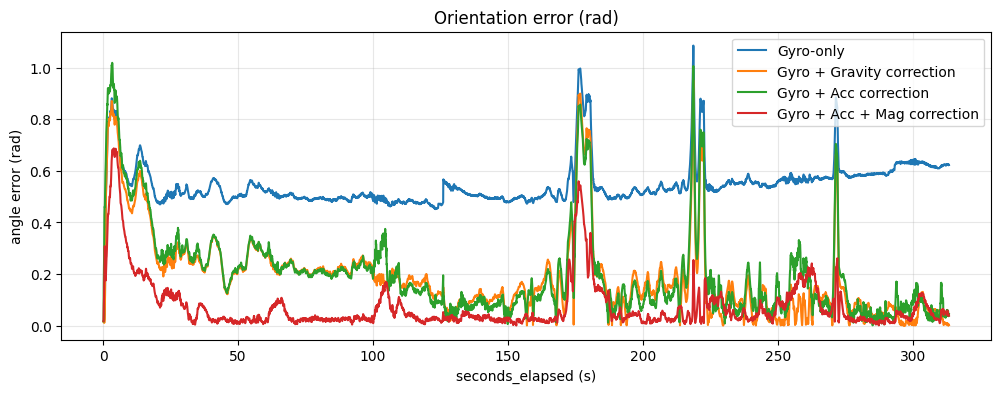

In [66]:
# -----------------------------
# Plot
# -----------------------------
plt.figure(figsize=(12,4))
plt.title("Orientation error (rad)")
plt.xlabel("seconds_elapsed (s)")
plt.ylabel("angle error (rad)")

plt.plot(t_custom, angle_err_gyro, label="Gyro-only")
plt.plot(t_custom, angle_err_gyro_grav, label="Gyro + Gravity correction")
plt.plot(t_custom, angle_err_gyro_acc, label="Gyro + Acc correction")
plt.plot(t_custom, angle_err_gyro_acc_mag, label="Gyro + Acc + Mag correction")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()